## Yamnet model for sound classification

In [27]:
# Imports.
import numpy as np
import soundfile as sf

import matplotlib.pyplot as plt

import params as yamnet_params
import yamnet as yamnet_model
import tensorflow as tf

import pandas as pd
from IPython.display import Audio, Javascript
from scipy.io import wavfile

In [31]:
print(tf.__version__)

2.3.0


In [1]:
# Upgrade pip first. Also make sure wheel is installed.
!python -m pip install --upgrade pip wheel


     |████████████████████████████████| 1.5MB 5.5MB/s 
Requirement already up-to-date: wheel in /usr/local/lib/python3.6/dist-packages (0.35.1)
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [ ]:
# Install dependences.
!pip install numpy resampy tensorflow soundfile


In [ ]:
# Clone TensorFlow models repo into a 'models' directory.
!git clone https://github.com/tensorflow/models.git
%cd models/research/audioset/yamnet


In [7]:
# Download data file into same directory as code.
!curl -O https://storage.googleapis.com/audioset/yamnet.h5

# Download audio for testing
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

!ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.5M  100 14.5M    0     0  21.6M      0 --:--:-- --:--:-- --:--:-- 21.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  153k  100  153k    0     0   702k      0 --:--:-- --:--:-- --:--:--  702k
total 15296
-rw-r--r-- 1 root root     7816 Nov  1 05:55 export.py
-rw-r--r-- 1 root root     7490 Nov  1 05:55 features.py
-rw-r--r-- 1 root root     2307 Nov  1 05:55 inference.py
-rw-r--r-- 1 root root     1847 Nov  1 05:55 params.py
-rw-r--r-- 1 root root     5012 Nov  1 05:55 README.md
-rw-r--r-- 1 root root   157484 Nov  1 05:55 speech_whistling2.wav
-rw-r--r-- 1 root root    14096 Nov  1 05:55 yamnet_class_map.csv
-rw-r--r-- 1 root root 15296092 Nov  1 05:55 yamnet.h5
-rw-r--r-- 1 root root     5549 Nov  1 05:55 y

In [ ]:
# Installation ready, let's test it.
!python yamnet_test.py
# If we see "Ran 4 tests ... OK ...", then we're all set.

In [ ]:
# Read info for csv file
csv_file = pd.read_csv('/content/models/research/audioset/yamnet/yamnet_class_map.csv')
csv_file.head()
print(csv_file)

In [56]:
# Conversion of your wav file to desired format
# Upload one rundom wav file to /content/
!ffmpeg -i '/content/ambulance_15.m4a' -acodec pcm_s16le -ac 1 -ar 16000 '/content/models/research/audioset/yamnet/generated_output.wav'

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [57]:
# Listen to audio
wav_file_name = '/content/models/research/audioset/yamnet/generated_output.wav'

# Loading audio samples from the wav file:
sample_rate, audio_samples = wavfile.read(wav_file_name, 'rb')

# Show some basic information about the audio.
duration = len(audio_samples)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

print(audio_samples[-100:-1])
print(audio_samples.shape)

Audio(wav_file_name)

Sample rate: 16000 Hz
Total duration: 15.49s
Size of the input: 247804
[  8651   6761   -132  -4115  -3684   -519   2641   2782  -1442  -6345
  -7435  -5861    764   8336  10415   6741   -977  -8227 -10892  -8159
  -2400    246     33  -1408  -4420  -6919  -4656   1477   7710   9996
   4859  -1043  -2491   1370   5036   5334   1413  -4120  -6066  -4715
    -74   8314  12901  10000   2902  -4502  -6124  -5225  -2305    948
   1142   -587  -3668  -7608  -7352   -362   6160   7431   2002  -7607
 -13403 -11286  -6179  -2287  -2507  -5131  -6438  -5593  -2334   5002
  10612   8872   2637  -5336 -10804 -11216  -7610  -2929  -1494  -2931
  -5149  -8461  -9562  -4901   3141   7760   3274  -7305 -12805 -10227
  -3660   3440   7055   3865   -487  -2024  -1762   1797   7573]
(247804,)


In [58]:
# Read in the audio.

wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
waveform = wav_data / 32768.0  #transform to [-1 to +1]

In [59]:
# The graph is designed for a sampling rate of 16 kHz, but higher rates should work too.
# We also generate scores at a 10 Hz frame rate.
params = yamnet_params.Params(sample_rate=sr, patch_hop_seconds=0.1)
print("Sample rate =", params.sample_rate)

Sample rate = 16000


In [60]:
# Set up the YAMNet model.
class_names = yamnet_model.class_names('/content/models/research/audioset/yamnet/yamnet_class_map.csv')
yamnet = yamnet_model.yamnet_frames_model(params)
yamnet.load_weights('/content/models/research/audioset/yamnet/yamnet.h5')

In [61]:
# Run the model.
scores, embeddings, spectrogram = yamnet(waveform)
scores = scores.numpy()
spectrogram = spectrogram.numpy()

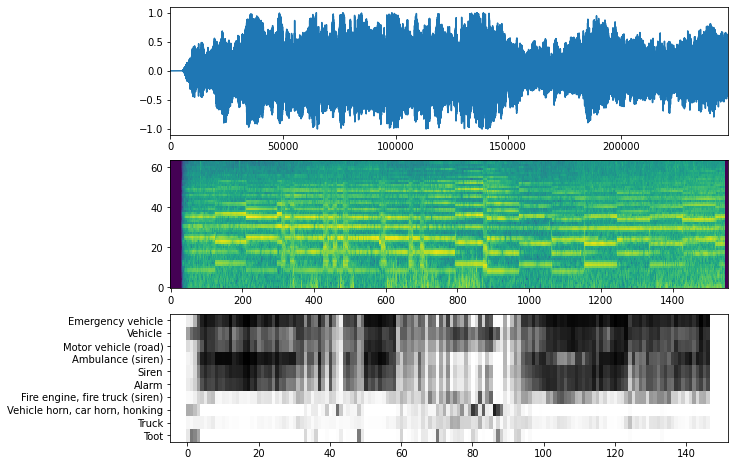

In [62]:
# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(3, 1, 3)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the patch_window_seconds (0.96s) context window to align with spectrogram.
patch_padding = (params.patch_window_seconds / 2) / params.patch_hop_seconds
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))

### Inference with the pyhton script


In [63]:
# Or you can do inference with python script
!python inference.py generated_output.wav

2020-11-01 06:49:03.168264: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-01 06:49:04.640386: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-01 06:49:04.649807: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-11-01 06:49:04.649847: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5dc2fe3da14d): /proc/driver/nvidia/version does not exist
2020-11-01 06:49:04.656221: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200000000 Hz
2020-11-01 06:49:04.656447: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5c828c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-01 06:49:04.656482: I tensorflow/com